# Complete Processing and Model Development for Chlamydia Data

## Imports

In [150]:
# data manipulation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from dtw import dtw

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

# data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import plot_tree, export_graphviz

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from sklearn.feature_selection import mutual_info_classif
import shap
from lime.lime_tabular import LimeTabularExplainer

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold

# type checking
from typing import Dict

# ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# evolutionary optimisation
import random
from thresholding import *

# statistical metrics
from scipy import stats
from scipy.fft import fft
from scipy.stats import kurtosis, skew, entropy, linregress, zscore, skew, kurtosis, shapiro
from scipy.spatial import distance

# other
from functools import partial

In [4]:
np.random.seed(42)
random.seed(42)

In [108]:
import warnings
warnings.filterwarnings('ignore')

## Data Download

### For EDA

In [2]:
ct_timeseries_df = pd.read_csv("./data/ingested/ct/CT_timeseries_long_format.csv")
ct_sample_types_df = pd.read_csv("./data/ingested/ct/CT_sample_types.csv")

complete_ct_df : pd.DataFrame = pd.merge(ct_timeseries_df, ct_sample_types_df, on='sample_id', how='left')

In [3]:
ct_timeseries = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
    lambda x: x.sort_values('mins')['value'].values,
    include_groups=False
)

ct_timeseries

sample_id     replicate
1-320-121     0            [2.77, 2.77, 2.77, 2.82, 2.98, 3.31, 3.66, 3.9...
              1            [2.59, 2.59, 2.6, 2.65, 2.83, 3.19, 3.56, 3.81...
              2            [2.82, 2.84, 2.84, 2.88, 3.07, 3.43, 3.84, 4.1...
              3            [2.83, 2.83, 2.85, 2.91, 3.09, 3.46, 3.86, 4.1...
1-320-129     0            [3.011289845, 3.097839933, 3.141931487, 3.1860...
                                                 ...                        
1-320-89-dup  3            [2.901607691, 2.918226291, 2.949801633, 3.0528...
1-320-90      0            [2.558476539, 2.668411078, 2.765020218, 2.8982...
              1            [2.486852522, 2.580130312, 2.661748379, 2.8049...
              2            [3.009874418, 3.153122454, 3.263056992, 3.4329...
              3            [2.55181384, 2.673408103, 2.770017243, 2.91159...
Length: 291, dtype: object

In [4]:
ct_outcomes = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
    lambda x: x['result'].values[0],
    include_groups = False
)
ct_outcomes

sample_id     replicate
1-320-121     0            positive
              1            positive
              2            positive
              3            positive
1-320-129     0            positive
                             ...   
1-320-89-dup  3            negative
1-320-90      0            negative
              1            negative
              2            negative
              3            negative
Length: 291, dtype: object

In [5]:
ct_gender = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
    lambda x: x['gender'].values[0],
    include_groups = False
)
ct_gender

sample_id     replicate
1-320-121     0            M
              1            M
              2            M
              3            M
1-320-129     0            F
                          ..
1-320-89-dup  3            F
1-320-90      0            F
              1            F
              2            F
              3            F
Length: 291, dtype: object

### For implementation

In [7]:
ct_timeseries_df = pd.read_csv("./data/ingested/ct/CT_timeseries_long_format.csv")
ct_sample_types_df = pd.read_csv("./data/ingested/ct/CT_sample_types.csv")

complete_ct_df : pd.DataFrame = pd.merge(ct_timeseries_df, ct_sample_types_df, on='sample_id', how='left')

In [8]:
complete_ct_df = complete_ct_df.dropna()

In [9]:
# normalisation
# ct_timeseries = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
#     lambda x: (
#         (x.sort_values('mins')['value'].values[:45] - x['value'].min()) /
#         (x['value'].max() - x['value'].min())
#     ),
#     include_groups=False
# )

# standardisation
ct_timeseries = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
    lambda x: (
        (x.sort_values('mins')['value'].values[:45] - x['value'].mean()) /
        x['value'].std()
    ),
    include_groups=False
)

In [10]:
series_to_remove = ct_timeseries[ct_timeseries.apply(lambda x: len(x) < 45)].index
ct_timeseries = ct_timeseries.drop(series_to_remove)

In [11]:
ct_outcomes = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
    lambda x: x['result'].values[0],
    include_groups = False
)
ct_outcomes = ct_outcomes.drop(series_to_remove)

In [12]:
ct_gender = complete_ct_df.groupby(['sample_id', 'replicate']).apply(
    lambda x: x['gender'].values[0],
    include_groups = False
)

## Exploratory Data Analysis

### Train-test splitting to avoid data leakage

In [9]:
ct_data = pd.merge(ct_timeseries.to_frame(name='timeseries'),
                         ct_outcomes.to_frame(name='result'), on=['sample_id', 'replicate'], how='left')
ct_data = pd.merge(ct_data, ct_gender.to_frame(name='gender'), on=['sample_id', 'replicate'], how='left')
ct_data

timeseries  \
sample_id    replicate                                                      
1-320-121    0          [2.77, 2.77, 2.77, 2.82, 2.98, 3.31, 3.66, 3.9...   
             1          [2.59, 2.59, 2.6, 2.65, 2.83, 3.19, 3.56, 3.81...   
             2          [2.82, 2.84, 2.84, 2.88, 3.07, 3.43, 3.84, 4.1...   
             3          [2.83, 2.83, 2.85, 2.91, 3.09, 3.46, 3.86, 4.1...   
1-320-129    0          [3.011289845, 3.097839933, 3.141931487, 3.1860...   
...                                                                   ...   
1-320-89-dup 3          [2.901607691, 2.918226291, 2.949801633, 3.0528...   
1-320-90     0          [2.558476539, 2.668411078, 2.765020218, 2.8982...   
             1          [2.486852522, 2.580130312, 2.661748379, 2.8049...   
             2          [3.009874418, 3.153122454, 3.263056992, 3.4329...   
             3          [2.55181384, 2.673408103, 2.770017243, 2.91159...   

                          result gender  
sample_id    replicate                   
1-320-121    0          positive      M  
             1          positive      M  
             2          positive      M  
             3          positive      M  
1-320-129    0          positive      F  
...                          ...    ...  
1-320-89-dup 3          negative      F  
1-320-90     0          negative      F  
             1          negative      F  
             2          negative      F  
             3          negative      F  

[291 rows x 3 columns]

In [93]:
y = ct_data['result']
X = ct_data.drop('result', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

In [68]:
print("Number of total entries: {}".format(len(X_train)+len(X_val)+len(X_test)))
print("Number of entries in training set: {}".format(len(X_train)))
print("Number of entries in validation set: {}".format(len(X_val)))
print("Number of entries in testing set: {}".format(len(X_test)))

Number of total entries: 291
Number of entries in training set: 203
Number of entries in validation set: 29
Number of entries in testing set: 59


### Preparing the training data

**Curves without normalisation**

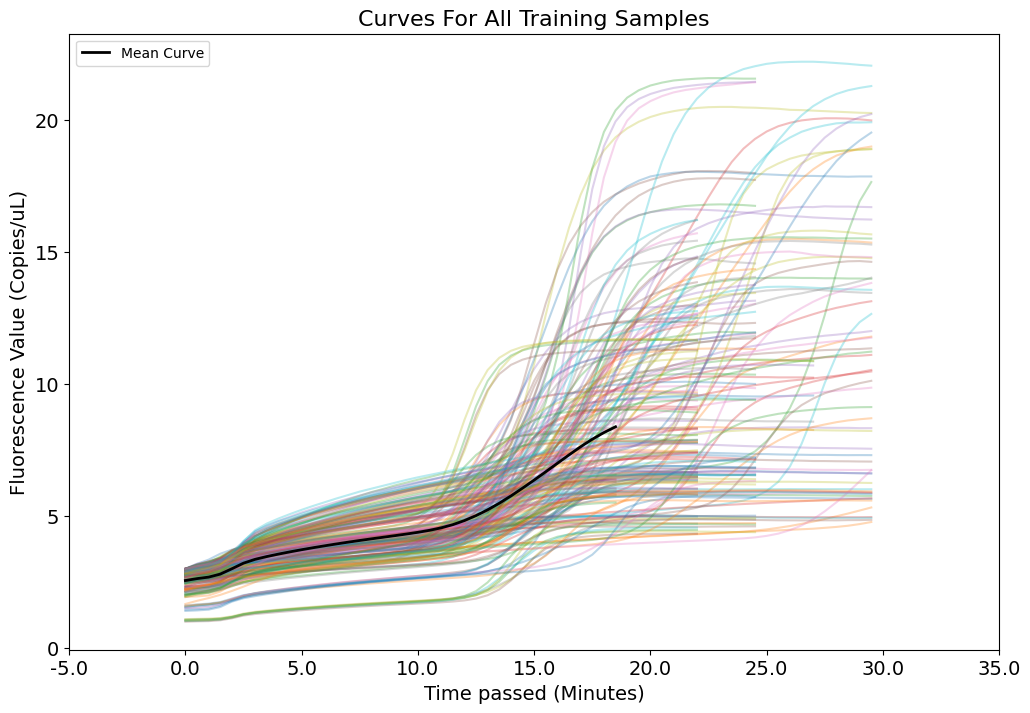

In [36]:
ct_sequences_array = np.vstack(X_train['timeseries'].values)

ct_mean_curve = np.mean(ct_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in X_train['timeseries']:
    plt.plot(series, alpha=0.3)
plt.plot(ct_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()

scale_factor =  30 / 60

original_ticks = plt.xticks()[0]
scaled_ticks = original_ticks * scale_factor

plt.title("Curves For All Training Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.ylabel('Fluorescence Value (Copies/uL)', fontsize=14)
plt.xticks(original_ticks, labels=scaled_ticks, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Viewing sequence lengths

In [94]:
X_train['timeseries'] = X_train['timeseries'].apply(lambda x: np.array(x)[~np.isnan(x)])

In [39]:
lengths = {}
for timeseries in X_train['timeseries'].values:
    if len(timeseries) in lengths:
        lengths[len(timeseries)] += 1
    else:
        lengths[len(timeseries)] = 0

lengths

{50: 49, 60: 64, 45: 71, 38: 8, 55: 6}

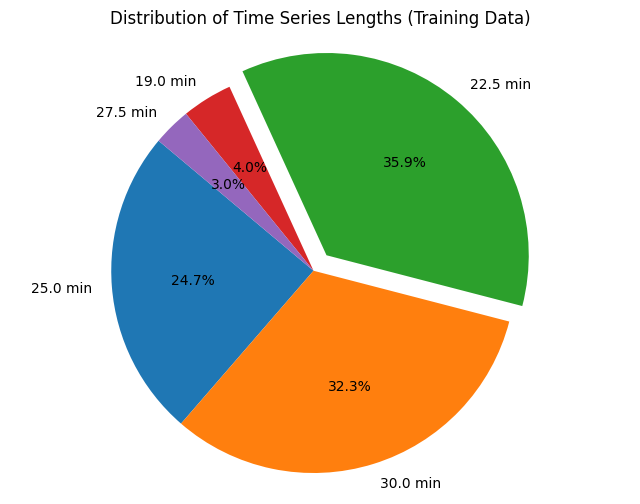

In [43]:
ct_pie_labels = [f"{length/2} min" for length in lengths.keys()]
ct_pie_sizes = list(lengths.values())

# explode the largest slice for emphasis
ct_pie_explode = [0.1 if size == max(ct_pie_sizes) else 0 for size in ct_pie_sizes]

plt.figure(figsize=(8, 6))
plt.pie(ct_pie_sizes, labels=ct_pie_labels, explode=ct_pie_explode, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Time-Series Lengths (Training Data)")
plt.axis('equal')
plt.show()

### Making all lengths consistent to 45 data points (22.5 minutes)

In [95]:
X_train['timeseries'] = X_train['timeseries'].apply(lambda x: x[:45])
X_val['timeseries'] = X_val['timeseries'].apply(lambda x: x[:45])
X_test['timeseries'] = X_test['timeseries'].apply(lambda x: x[:45])

train_series_to_remove = X_train[X_train['timeseries'].apply(lambda x: len(x) < 45)].index
val_series_to_remove = X_val[X_val['timeseries'].apply(lambda x: len(x) < 45)].index
test_series_to_remove = X_test[X_test['timeseries'].apply(lambda x: len(x) < 45)].index

X_train = X_train.drop(train_series_to_remove)
X_val = X_val.drop(val_series_to_remove)
X_test = X_test.drop(test_series_to_remove)

y_train = y_train.drop(train_series_to_remove)
y_val = y_val.drop(val_series_to_remove)
y_test = y_test.drop(test_series_to_remove)

In [13]:
lengths = {}
for timeseries in X_train['timeseries'].values:
    if len(timeseries) in lengths:
        lengths[len(timeseries)] += 1
    else:
        lengths[len(timeseries)] = 0

lengths

{45: 193}

In [14]:
lengths = {}
for timeseries in X_val['timeseries'].values:
    if len(timeseries) in lengths:
        lengths[len(timeseries)] += 1
    else:
        lengths[len(timeseries)] = 0

lengths

{45: 28}

In [15]:
lengths = {}
for timeseries in X_test['timeseries'].values:
    if len(timeseries) in lengths:
        lengths[len(timeseries)] += 1
    else:
        lengths[len(timeseries)] = 0

lengths

{45: 58}

### Data scaling

**Normalisation**

In [106]:
X_train['timeseries'] = X_train['timeseries'].apply(lambda x: (np.array(x) - np.min(x)) / (np.max(x) - np.min(x)) if len(x) > 1 else x)

**Standardisation**

In [29]:
#X_train['timeseries'] = X_train['timeseries'].apply(lambda x: (np.array(x) - np.mean(x)) / np.std(x) if len(x) > 1 else x)

### Visualising the curves

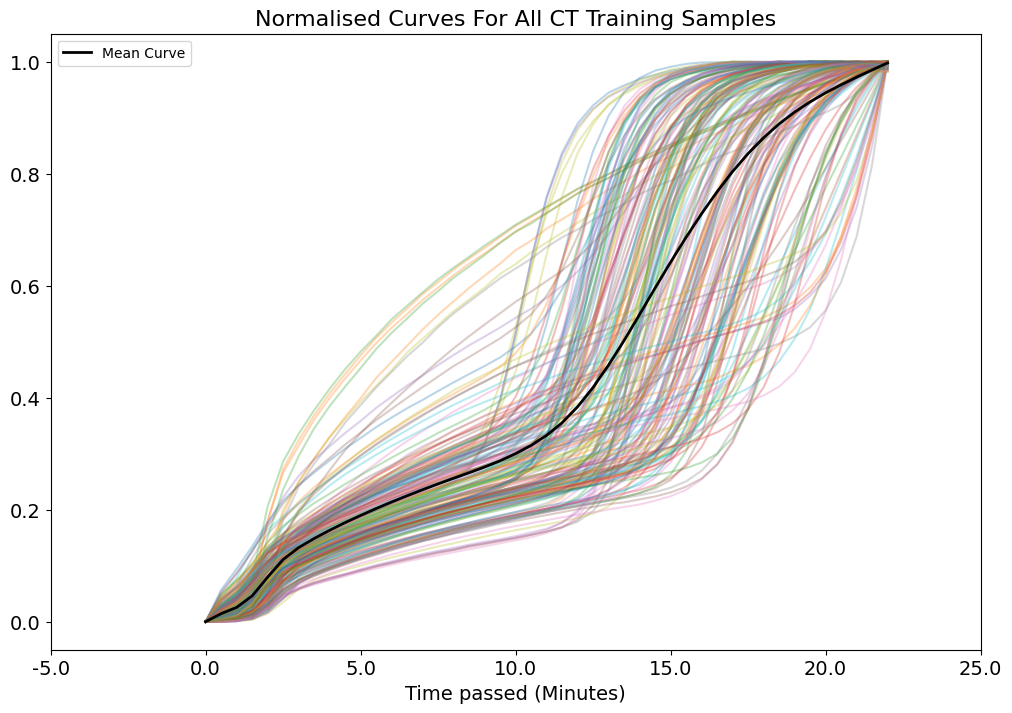

In [82]:
ct_sequences_array = np.vstack(X_train['timeseries'].values)

ct_mean_curve = np.mean(ct_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in X_train['timeseries']:
    plt.plot(series, alpha=0.3)

scale_factor =  30 / 60

original_ticks = plt.xticks()[0]
scaled_ticks = original_ticks * scale_factor

plt.plot(ct_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()
plt.title("Normalised Curves For All CT Training Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.xticks(original_ticks, labels=scaled_ticks, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

#### Outlier removal

In [96]:
def extract_metrics(series):
    diff = np.diff(series)
    return {
        'std': np.std(series),
        'mean_abs_change': np.mean(np.abs(diff)),
        'autocorr': pd.Series(series).autocorr(lag=1)
    }

metrics_df = pd.DataFrame([
    extract_metrics(ts) for ts in X_train['timeseries']
])

outlier_flags = (np.abs(zscore(metrics_df)) > 3).any(axis=1)
metric_outliers = metrics_df[outlier_flags]

In [97]:
def total_variation(series):
    return np.sum(np.abs(np.diff(series)))

tv_scores = [total_variation(ts) for ts in X_train['timeseries']]
variation_threshold = np.percentile(tv_scores, 92) # top 8% most erratic
variation_outlier_indices = [i for i, tv in enumerate(tv_scores) if tv > variation_threshold]

In [98]:
total_outliers = np.array(list(set(metric_outliers.index.values).union(variation_outlier_indices)))
outlier_labels = X_train['timeseries'].index[total_outliers]

In [25]:
print("Total number of outliers:", len(total_outliers))
print("Outlier indices for normalisation:" + str(total_outliers))

Total number of outliers: 19
Outlier indices for normalisation:[ 24 153 154  27  28 152  30 159 161 164 166 176  68  77  80  82  94 112
 118]


In [33]:
print("Total number of outliers:", len(total_outliers))
print("Outlier indices for standardisation:", total_outliers)

Total number of outliers: 16
Outlier indices for standardisation: [ 36 101  69 103 168  59 106 155 109 176  48  86 126  27  61  94]


In [99]:
X_train = X_train.drop(outlier_labels)
y_train = y_train.drop(outlier_labels)

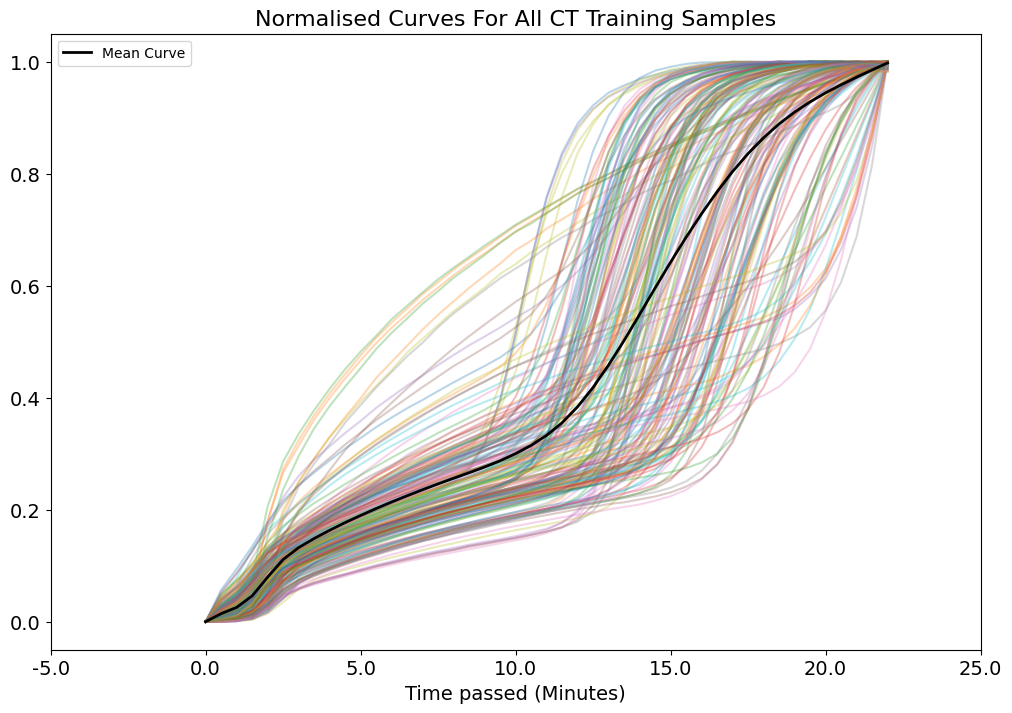

In [45]:
ct_sequences_array = np.vstack(X_train['timeseries'].values)

ct_mean_curve = np.mean(ct_sequences_array, axis=0)

plt.figure(figsize=(12, 8))
for series in X_train['timeseries']:
    plt.plot(series, alpha=0.3)

scale_factor =  30 / 60

original_ticks = plt.xticks()[0]
scaled_ticks = original_ticks * scale_factor

plt.plot(ct_mean_curve, color='black', linewidth=2, label='Mean Curve')
plt.legend()
plt.title("Normalised Curves For All CT Training Samples", fontsize=16)
plt.xlabel('Time passed (Minutes)', fontsize=14)
plt.xticks(original_ticks, labels=scaled_ticks, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Checking gender and outcome distributions

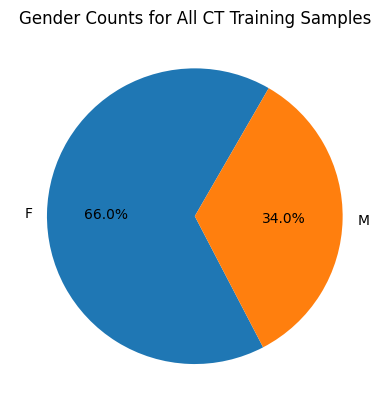

In [51]:
X_train['gender'].value_counts().plot.pie(autopct='%1.1f%%',startangle=60)
plt.ylabel('')
plt.title('Gender Counts for All CT Training Samples')
plt.show()

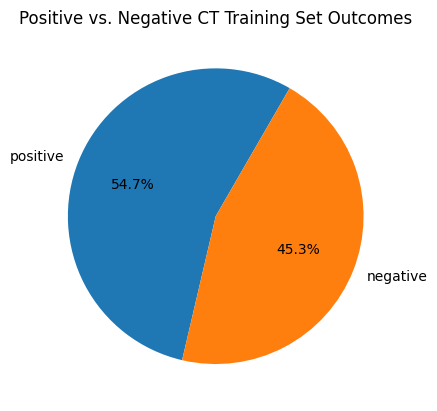

In [50]:
y_train.value_counts().plot.pie(autopct='%1.1f%%',startangle=60)
plt.ylabel('')
plt.title('Positive vs. Negative CT Training Set Outcomes')
plt.show()

In [108]:
mask_male_positive = (X_train['gender'] == 'M') & (y_train == 'positive')
mask_male_negative = (X_train['gender'] == 'M') & (y_train == 'negative')
mask_female_positive = (X_train['gender'] == 'F') & (y_train == 'positive')
mask_female_negative = (X_train['gender'] == 'F') & (y_train == 'negative')

male_positives_sequences_array = np.vstack(X_train[mask_male_positive]['timeseries'].values)
male_negatives_sequences_array = np.vstack(X_train[mask_male_negative]['timeseries'].values)
female_positives_sequences_array = np.vstack(X_train[mask_female_positive]['timeseries'].values)
female_negatives_sequences_array = np.vstack(X_train[mask_female_negative]['timeseries'].values)

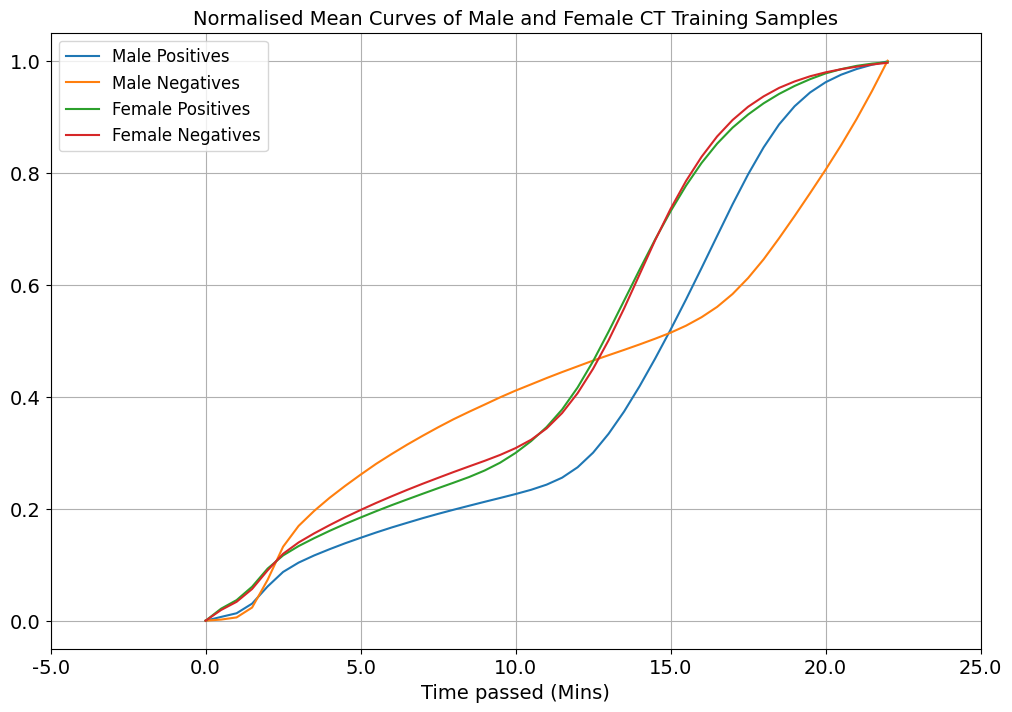

In [110]:
male_positives_mean_curve = np.mean(male_positives_sequences_array, axis=0)
male_negatives_mean_curve = np.mean(male_negatives_sequences_array, axis=0)
female_positives_mean_curve = np.mean(female_positives_sequences_array, axis=0)
female_negatives_mean_curve = np.mean(female_negatives_sequences_array, axis=0)

male_positives_mean_curve = male_positives_mean_curve[~np.isnan(male_positives_mean_curve)]
male_negatives_mean_curve = male_negatives_mean_curve[~np.isnan(male_negatives_mean_curve)]
female_positives_mean_curve = female_positives_mean_curve[~np.isnan(female_positives_mean_curve)]
female_negatives_mean_curve = female_negatives_mean_curve[~np.isnan(female_negatives_mean_curve)]

plt.figure(figsize=(12, 8))
plt.plot(male_positives_mean_curve, label='Male Positives')
plt.plot(male_negatives_mean_curve, label='Male Negatives')
plt.plot(female_positives_mean_curve, label='Female Positives')
plt.plot(female_negatives_mean_curve, label='Female Negatives')

scale_factor =  30 / 60

original_ticks = plt.xticks()[0]
scaled_ticks = original_ticks * scale_factor
plt.xticks(original_ticks, labels=scaled_ticks, fontsize=14)
plt.yticks(fontsize=14)

plt.title('Normalised Mean Curves of Male and Female CT Training Samples', fontsize=14)
plt.xlabel('Time passed (Mins)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

DTW distance: 0.42244841561918295


Text(0, 0.5, '')

<Figure size 1200x800 with 0 Axes>

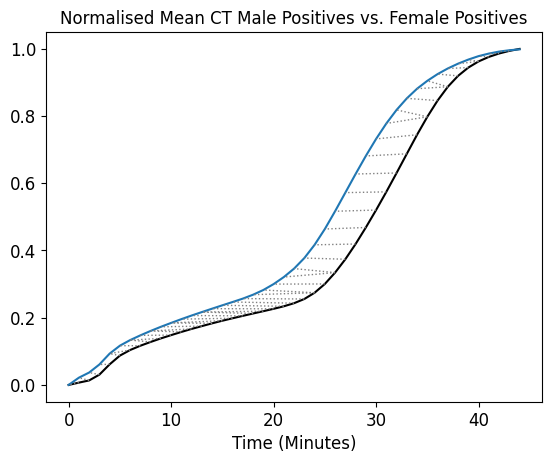

In [113]:
alignment = dtw(male_positives_mean_curve, female_positives_mean_curve, keep_internals=True)

print(f"DTW distance: {alignment.distance}")

plt.figure(figsize=(12, 8))
alignment.plot(type="twoway")
plt.title("Normalised Mean CT Male Positives vs. Female Positives", fontsize=12)
plt.xlabel("Time (Minutes)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("")

## Thresholding Preprocessing

### Outlier removal

In [13]:
def extract_metrics(series):
    diff = np.diff(series)
    return {
        'std': np.std(series),
        'mean_abs_change': np.mean(np.abs(diff)),
        'autocorr': pd.Series(series).autocorr(lag=1)
    }

metrics_df = pd.DataFrame([
    extract_metrics(ts) for ts in ct_timeseries
])

outlier_flags = (np.abs(zscore(metrics_df)) > 3).any(axis=1)
metric_outliers = metrics_df[outlier_flags]

In [14]:
def total_variation(series):
    return np.sum(np.abs(np.diff(series)))

tv_scores = [total_variation(ts) for ts in ct_timeseries]
variation_threshold = np.percentile(tv_scores, 92) # top 8% most erratic
variation_outlier_indices = [i for i, tv in enumerate(tv_scores) if tv > variation_threshold]

In [15]:
total_outliers = np.array(list(set(metric_outliers.index.values).union(variation_outlier_indices)))
# outlier_labels = ct_timeseries.index[total_outliers]
outlier_labels = ct_timeseries.index[metric_outliers.index.values]

In [16]:
cleaner_ct_timeseries = ct_timeseries.copy()
cleaner_ct_timeseries = cleaner_ct_timeseries.drop(outlier_labels)

cleaner_ct_outcomes = ct_outcomes.copy()
cleaner_ct_outcomes = cleaner_ct_outcomes.drop(outlier_labels)

In [17]:
print(f"Number of entries of original series: {len(ct_timeseries)}")
print(f"Number of entries of cleaned series: {len(cleaner_ct_timeseries)}")
print(f"Number of entries removed: {len(ct_timeseries)-len(cleaner_ct_timeseries)}")

Number of entries of original series: 279
Number of entries of cleaned series: 268
Number of entries removed: 11


### Label encoding, data balancing, and data splitting

In [18]:
# label encoding
cleaner_ct_outcomes = cleaner_ct_outcomes.map({"positive":1, "negative":0})

In [24]:
# data balancing
X = cleaner_ct_timeseries.to_frame(name='timeseries')
y = cleaner_ct_outcomes

X_resampled, y_resampled = RandomUnderSampler(random_state=42).fit_resample(X, y)

In [25]:
# data splitting
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

## Thresholding

In [26]:
pop, hof, logbook = perform_thresholding(X_train, y_train, 2)

/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg                                          	std                                          
0  	200   	[0.61755952 0.33916667 0.22767857 0.4783631 ]	[0.41994111 0.36899959 0.30063457 0.06257699]
1  	200   	[0.36827381 0.60083333 0.38470238 0.48455357]	[0.35724022 0.30911812 0.32539784 0.06316286]
2  	200   	[0.48154762 0.5502381  0.46035714 0.51589286]	[0.34126978 0.29197059 0.32342438 0.0555077 ]
3  	200   	[0.51470238 0.56357143 0.46232143 0.5391369 ]	[0.33659117 0.28774684 0.31465477 0.04020584]
4  	200   	[0.52482143 0.56577381 0.4697619  0.54529762]	[0.33035398 0.28172547 0.30454754 0.03457401]
5  	200   	[0.47642857 0.60880952 0.48190476 0.54261905]	[0.32237726 0.27078045 0.31480603 0.03353172]
6  	200   	[0.45303571 0.63297619 0.45005952 0.54300595]	[0.33104486 0.27559488 0.31101221 0.03279453]
7  	200   	[0.44053571 0.64827381 0.47154762 0.54440476]	[0.31592622 0.26372957 0.31429877 0.03096291]
8  	200   	[0.3910119 0.6902381 0.4114881 0.540625 ]    	[0.32790023 0.27

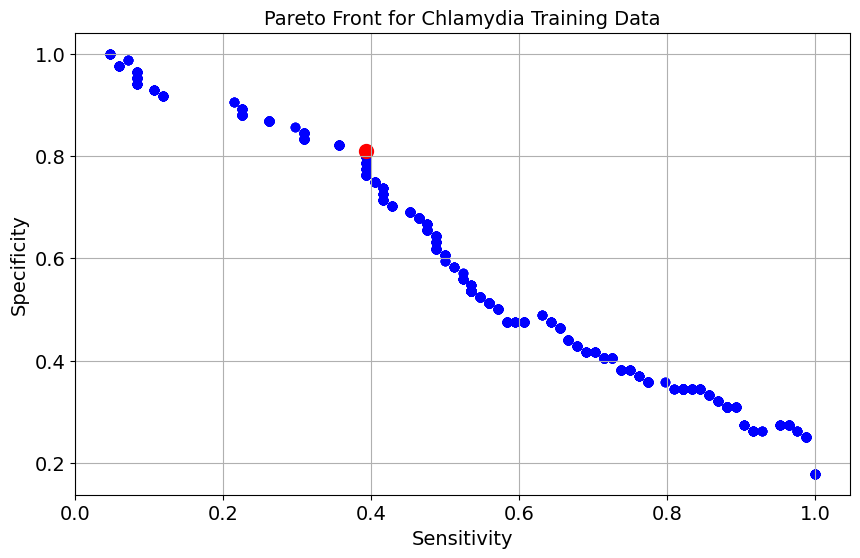

In [27]:
def find_knee_point(hof):
    points = np.array([ind.fitness.values for ind in hof])

    norm_points = (points - points.min(axis=0)) / (points.max(axis=0) - points.min(axis=0))

    dists = distance.cdist(norm_points, np.array([[1, 1, 1, 1]]), 'euclidean')
    knee_idx = np.argmin(dists)

    return hof[knee_idx]

def plot_pareto_front(hof):
    plt.figure(figsize=(10,6))
    sens = [ind.fitness.values[0] for ind in hof]
    spec = [ind.fitness.values[1] for ind in hof]

    plt.scatter(sens, spec, c='blue')
    plt.xlabel("Sensitivity", fontsize=14)
    plt.ylabel("Specificity", fontsize=14)
    plt.title("Pareto Front for Chlamydia Training Data", fontsize=14)
    plt.grid(True)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    knee = find_knee_point(hof)
    plt.scatter([knee.fitness.values[0]], [knee.fitness.values[1]], c='red', s=100)

    plt.show()

plot_pareto_front(hof)
best_solution = find_knee_point(hof)

In [28]:
print("The best criterions are as follows.")
print(f"- Number of bases to include: {best_solution[0]}")
print(f"- Standard deviation: {best_solution[1]}")
print(f"- Classification threshold: {best_solution[2]}")

The best criterions are as follows.
- Number of bases to include: 7
- Standard deviation: 7.2547923186663095
- Classification threshold: 12


## Preprocessing

### Main features

**Note: must run thresholding preprocessing and thresholding beforehand**

In [29]:
def extract_arima_features(series: np.ndarray) -> Dict[str, np.ndarray]:
    model = ARIMA(series, order=(1,1,1))
    results = model.fit()

    return {
            'ar_coef': results.arparams[0] if len(results.arparams) > 0 else 0,
            'ma_coef': results.maparams[0] if len(results.maparams) > 0 else 0,
            'resid_mean': results.resid.mean(),
            'resid_std': results.resid.std(),
            'aic': results.aic,
            'hqic': results.hqic,
            }

In [30]:
def get_aggregated_stats(series):
    mean = np.mean(series)
    std = np.std(series)
    median = np.median(series)
    q3 = np.percentile(series, 75)
    q1 = np.percentile(series, 25)
    iqr = q3 - q1
    skew_val = skew(series)
    kurtosis_val = kurtosis(series)
    spectral_entropy = entropy(np.abs(np.fft.fft(series)))
    trend_slope = linregress(np.arange(len(series)), series).slope
    max_jump = np.max(np.abs(np.diff(series)))
    return mean, std, median, iqr, skew_val, kurtosis_val, spectral_entropy, max_jump

In [31]:
def get_mean_averages(series, cutoff=10, which='both'):
    early = series[:cutoff]
    after = series[cutoff:]
    early_mean = np.mean(early)
    after_mean = np.mean(after)

    if which == 'both':
        return early_mean, after_mean
    elif which == 'early':
        return early_mean
    elif which == 'after':
        return after_mean

In [32]:
def get_dynamic_signalling(series, mean_cutoff=10):
    max_index = np.argmax(series)
    auc = np.trapz(series, dx=0.5)
    early_mean, after_mean = get_mean_averages(series, mean_cutoff)
    if len(series) > 1:
      autocorr_lag1 = np.corrcoef(series[:-1], series[1:])[0,1]
    else:
      autocorr_lag1 = np.nan # handle cases where autocorrelation cannot be calculated
    mean_abs_change = np.mean(np.abs(np.diff(series)))
    mean_change = np.mean(np.diff(series))
    second_deriv = np.diff(series, n=2)
    inflection_index = np.argmax(second_deriv)
    first_deriv = np.diff(series)
    time_to_half = np.argmax(series >= 0.5)
    return max_index, auc, early_mean, after_mean, autocorr_lag1, mean_abs_change, mean_change, inflection_index, time_to_half

In [33]:
def extract_features_from_series(multi_series, mean_cutoff=10):
    grouped = multi_series.groupby(level=['sample_id', 'replicate'])

    feature_rows = []
    index_tuples = []

    for (sample_id, replicate), group_series in grouped:
        flattened = np.array(group_series.iloc[0])

        agg_stats = get_aggregated_stats(flattened)
        dyn_signals = get_dynamic_signalling(flattened, mean_cutoff)

        all_features = list(agg_stats) + list(dyn_signals)
        feature_rows.append(all_features)
        index_tuples.append((sample_id, replicate))

    feature_names = [
        "mean", "std", "median", "iqr", "skew", "kurtosis",
        "spectral_entropy", "max_jump",
        "max_index", "auc", "early_mean", "after_mean",
        "autocorr_lag1", "mean_abs_change", "mean_change",
        "inflection_index", "time_to_half"
    ]

    index = pd.MultiIndex.from_tuples(index_tuples, names=['sample_id', 'replicate'])

    features_df = pd.DataFrame(feature_rows, index=index, columns=feature_names)

    return features_df

In [34]:
arima_features = pd.DataFrame([extract_arima_features(ts) for ts in cleaner_ct_timeseries.values])
arima_features.index = cleaner_ct_timeseries.index

/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

In [35]:
features_df = extract_features_from_series(cleaner_ct_timeseries, mean_cutoff=11)

In [36]:
features_df = pd.merge(features_df, cleaner_ct_outcomes.to_frame('result'), on=['sample_id', 'replicate'])

In [37]:
features_df = pd.merge(features_df, cleaner_ct_timeseries.to_frame('timeseries'), on=['sample_id', 'replicate'], how='left')

In [38]:
features_df['meets_threshold'] = get_thresholding_values(features_df.copy(), best_solution[2], features_df['result'], num_base_count=best_solution[0], sigma_multiplier=best_solution[1], index_time_scale=2)['meets_threshold']

**Adding gender**

In [39]:
features_df = pd.merge(features_df, ct_gender.to_frame('gender'), on=['sample_id', 'replicate'])
features_df = pd.get_dummies(features_df, columns=['gender'], dtype=int)

**Adding ARIMA**

In [40]:
features_df = pd.merge(features_df, arima_features, on=['sample_id', 'replicate'], how='left')

### Adding kNN predictions - model stacking

In [93]:
knn_X = cleaner_ct_timeseries.to_frame('timeseries')
knn_y = cleaner_ct_outcomes

knn_X_resampled, knn_y_resampled = RandomUnderSampler(random_state=42).fit_resample(knn_X, knn_y)

In [94]:
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(knn_X_resampled, knn_y_resampled, test_size=0.2, random_state=42, stratify = knn_y_resampled)
knn_X_train, knn_X_val, knn_y_train, knn_y_val = train_test_split(knn_X_train, knn_y_train, test_size=0.125, random_state=42, stratify = knn_y_train)

In [43]:
def dtw_distance(x, y):
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    alignment = dtw(x, y, distance_only=True)
    return alignment.distance

In [95]:
knn_X_train_array = [ts[0] for ts in knn_X_train.values]
knn_X_val_array = [ts[0] for ts in knn_X_val.values]
knn_X_test_array = [ts[0] for ts in knn_X_test.values]

In [96]:
knn = KNeighborsClassifier(
    n_neighbors=3,
    metric=dtw_distance,
    algorithm='brute'
)

knn.fit(knn_X_train_array, knn_y_train)

print(classification_report(knn.predict(knn_X_train_array), knn_y_train))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        82
           1       0.87      0.85      0.86        86

    accuracy                           0.86       168
   macro avg       0.86      0.86      0.86       168
weighted avg       0.86      0.86      0.86       168



In [97]:
print("Classification report for training data:")
print(classification_report(knn_y_train, knn.predict(knn_X_train_array)))
print("Training ROC-AUC score:", roc_auc_score(knn_y_train, knn.predict(knn_X_train_array)), end='\n\n')

print("Classification report for validation data:\n")
print(classification_report(knn_y_val, knn.predict(knn_X_val_array)))
print("Validation ROC-AUC score:", roc_auc_score(knn_y_val, knn.predict(knn_X_val_array)), end='\n\n')

print("Classification report for validation data:\n")
print(classification_report(knn_y_test, knn.predict(knn_X_test_array)))
print("Validation ROC-AUC score:", roc_auc_score(knn_y_test, knn.predict(knn_X_test_array)), end='\n\n')

Classification report for training data:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86        84
           1       0.85      0.87      0.86        84

    accuracy                           0.86       168
   macro avg       0.86      0.86      0.86       168
weighted avg       0.86      0.86      0.86       168

Training ROC-AUC score: 0.8571428571428572

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        12
           1       0.69      0.69      0.69        13

    accuracy                           0.68        25
   macro avg       0.68      0.68      0.68        25
weighted avg       0.68      0.68      0.68        25

Validation ROC-AUC score: 0.6794871794871796

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.78      0.56      0.65        25
           1      

#### K hyperparameter optimisation using the Elbow method

In [264]:
k_range = range(1, 30)
scores = [cross_val_score(KNeighborsClassifier(n_neighbors=k, metric=dtw_distance, algorithm='brute'), knn_X_train_array,
                          knn_y_train, cv=5).mean() for k in k_range]

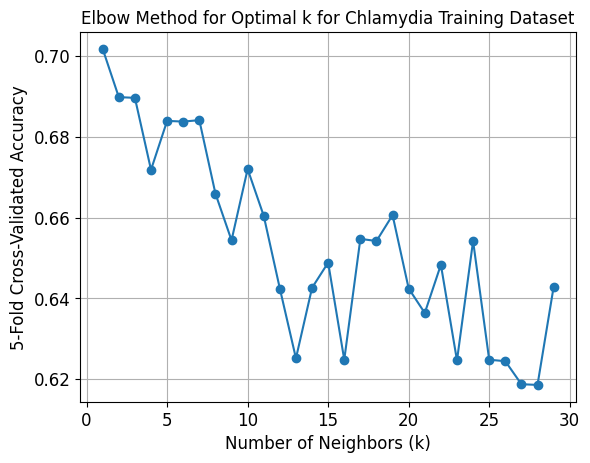

In [266]:
plt.plot(k_range, scores, marker='o')
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('5-Fold Cross-Validated Accuracy', fontsize=12)
plt.title('Elbow Method for Optimal k for Chlamydia Training Dataset', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

#### Integrating results back into features

In [46]:
gen_y = features_df['result']
gen_X = features_df.drop('result', axis=1)
gen_X_resampled, gen_y_resampled = RandomUnderSampler(random_state=42).fit_resample(gen_X, gen_y)

In [47]:
knn_X_resampled_array = [ts[0] for ts in knn_X_resampled.values]
knn_probs = knn.predict_proba(knn_X_resampled_array)
knn_probs_df = pd.DataFrame(knn_probs, columns=[f'knn_prob_{i}' for i in range(knn_probs.shape[1])])
knn_probs_df.index = knn_X_resampled.index
gen_X_resampled = pd.merge(gen_X_resampled, knn_probs_df, on=['sample_id', 'replicate'], how='left')

### Feature engineering

#### Correlation analysis - verifying whether normality is present

In [278]:
results = []

for feature in gen_X_resampled.drop(columns=['timeseries', 'knn_prob_0', 'knn_prob_1', 'meets_threshold']).columns:
    statistic, p_value = shapiro(features_df[feature])
    normally_distributed = p_value > 0.05

    results.append({
        'Feature': feature,
        'P-value (4 d.p.)': round(p_value, 4),
        'Normally Distributed': normally_distributed
    })

distribution_df = pd.DataFrame(results)

distribution_df

Feature  P-value (4 d.p.)  Normally Distributed
0               mean            0.0000                 False
1                std            0.0000                 False
2             median            0.0000                 False
3                iqr            0.0000                 False
4               skew            0.0001                 False
5           kurtosis            0.0000                 False
6   spectral_entropy            0.0130                 False
7           max_jump            0.0001                 False
8          max_index            0.0000                 False
9                auc            0.0000                 False
10        early_mean            0.0000                 False
11        after_mean            0.0000                 False
12     autocorr_lag1            0.0000                 False
13   mean_abs_change            0.0000                 False
14       mean_change            0.0000                 False
15  inflection_index            0.0000                 False
16        max_growth            0.0001                 False
17      time_to_half            0.0000                 False
18          gender_F            0.0000                 False
19          gender_M            0.0000                 False
20           ar_coef            0.0000                 False
21           ma_coef            0.0000                 False
22        resid_mean            0.0000                 False
23         resid_std            0.0000                 False
24               aic            0.0000                 False
25              hqic            0.0000                 False

#### Correlation analysis heatmap

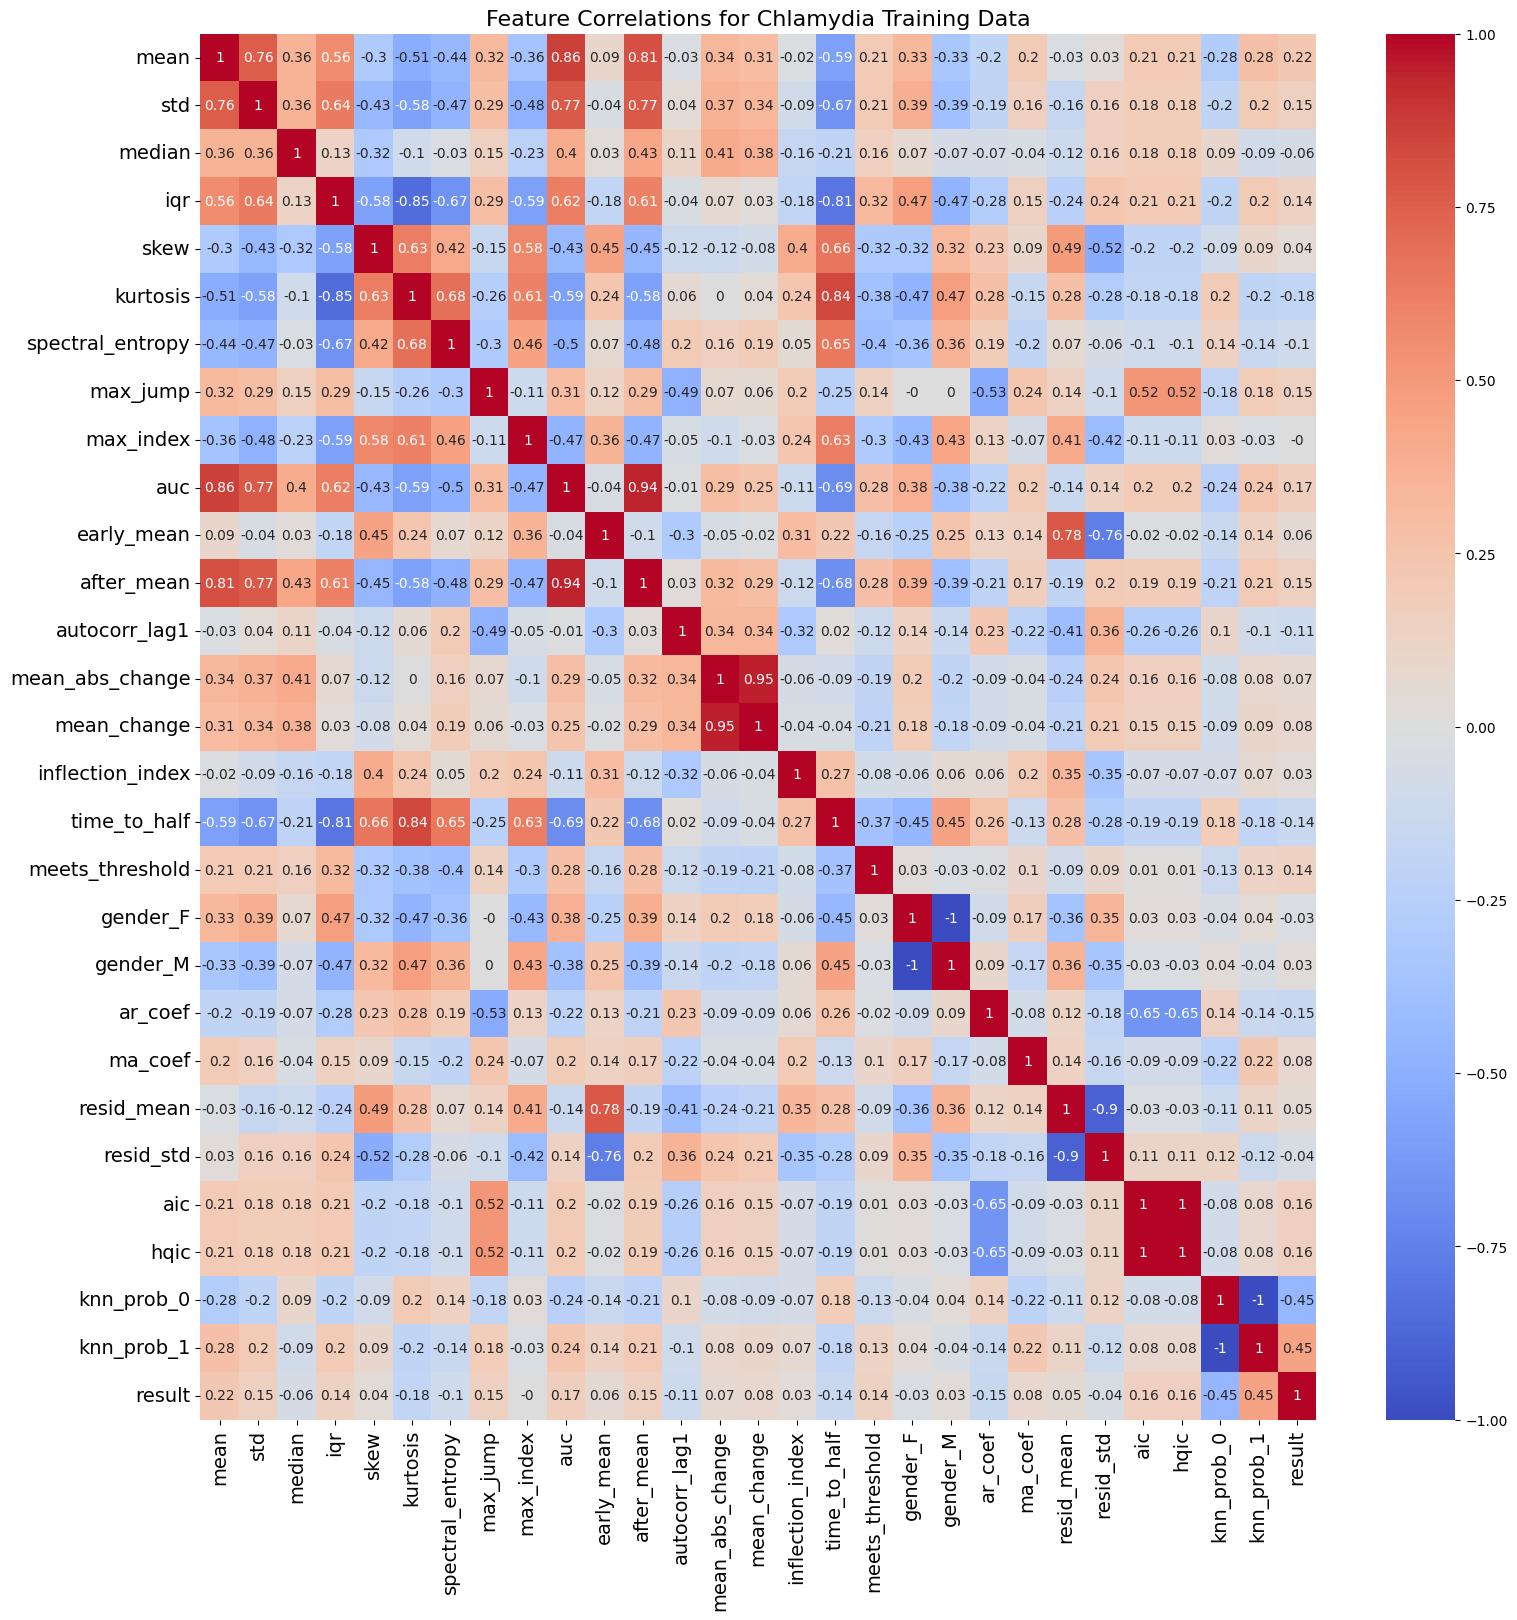

In [279]:
tmp_features = gen_X_resampled.copy()
tmp_features['result'] = gen_y_resampled
tmp_features.drop(columns=['timeseries', 'max_growth'], inplace=True, axis=1)
corr_matrix = tmp_features.corr(method='kendall').round(2)
target_column = 'result'

plt.figure(figsize=(18, 18))
target_corr = corr_matrix[[target_column]].sort_values(by=target_column, ascending=False)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title(f"Feature Correlations for Chlamydia Training Data", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

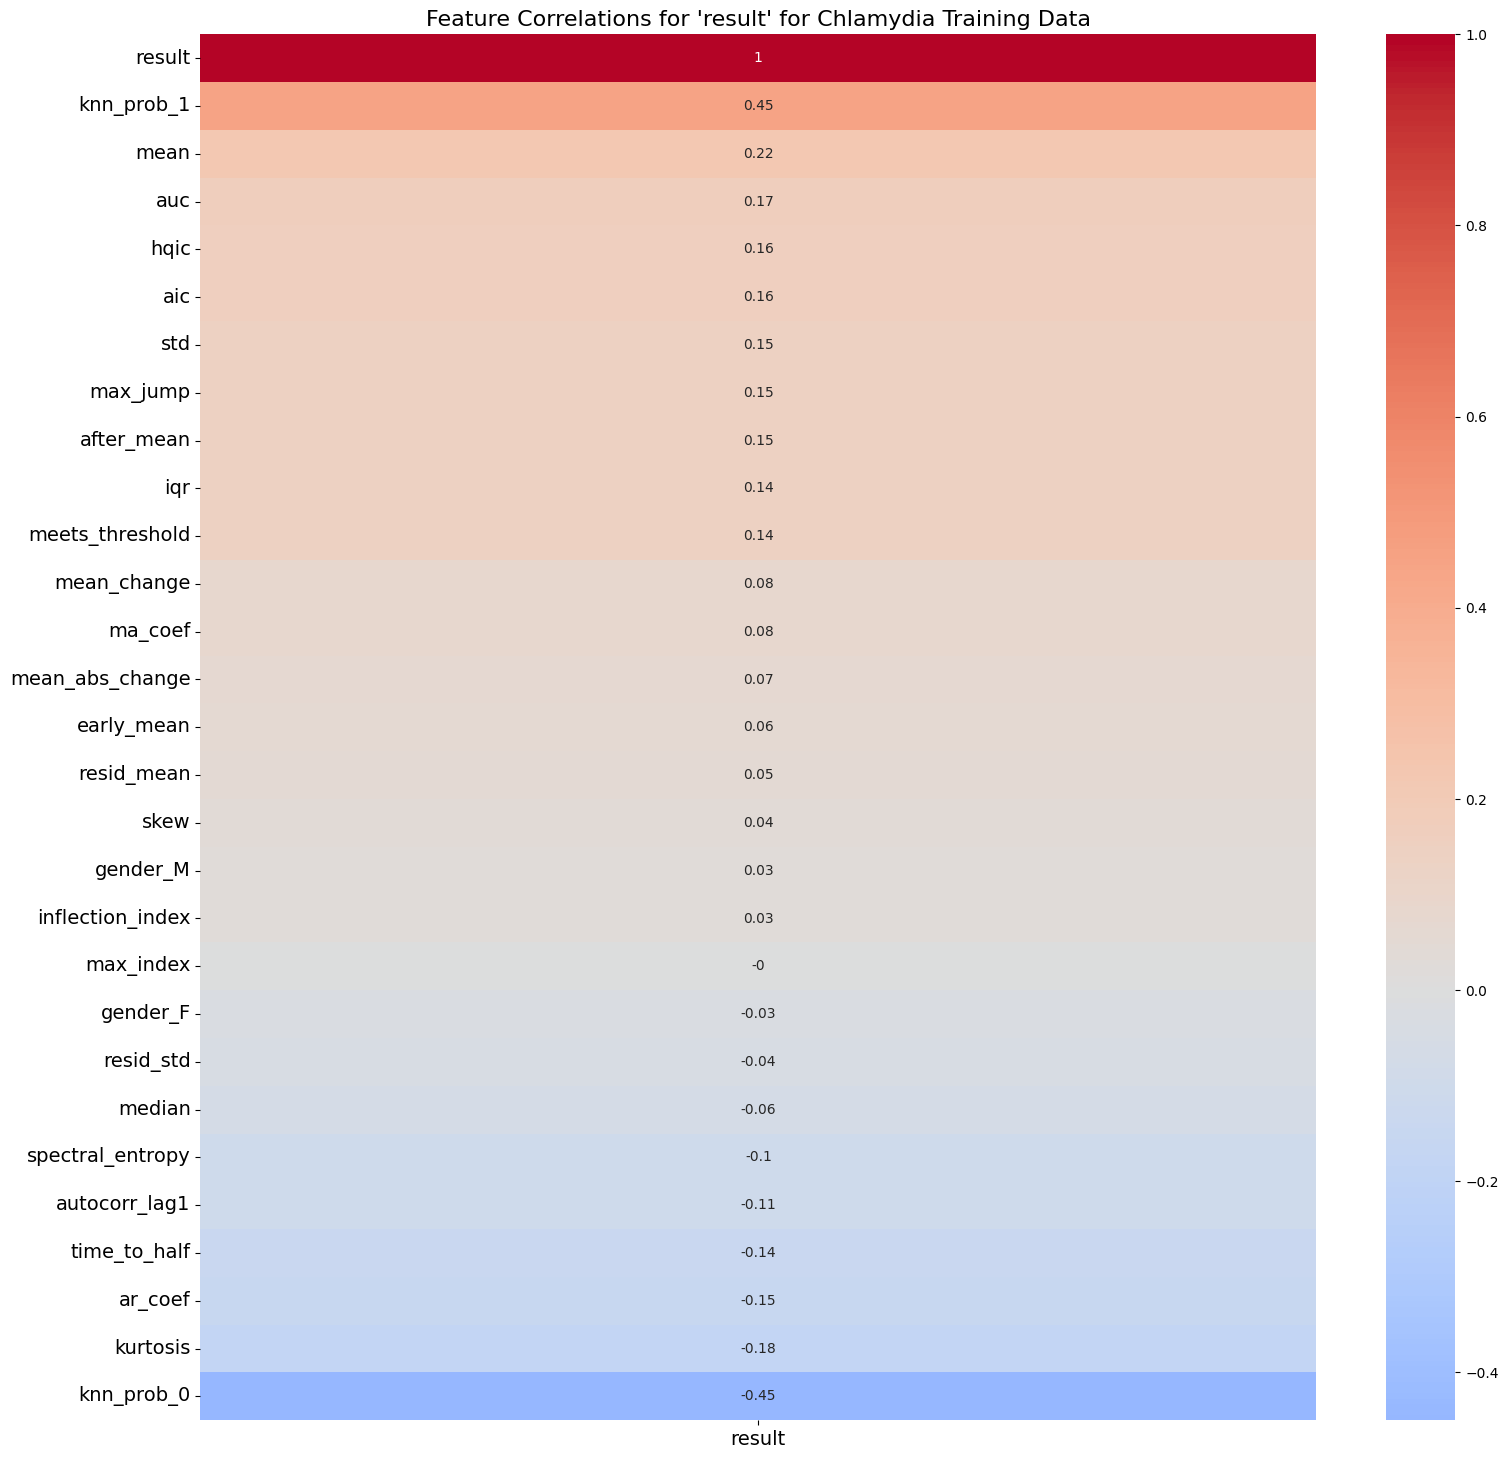

In [283]:
tmp_features = gen_X_resampled.copy()
tmp_features['result'] = gen_y_resampled
tmp_features.drop(columns=['timeseries', 'max_growth'], inplace=True, axis=1)
corr_matrix = tmp_features.corr(method='kendall').round(2)
target_column = 'result'

plt.figure(figsize=(18, 18))
target_corr = corr_matrix[[target_column]].sort_values(by=target_column, ascending=False)
sns.heatmap(target_corr, annot=True, cmap='coolwarm', center=0)
plt.title(f"Feature Correlations for 'result' for Chlamydia Training Data", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

#### Final data splitting

In [80]:
# initial feature removal based on correlation and mutual info gain
# gen_X_final = gen_X_resampled.drop(columns=['timeseries', 'meets_threshold', 'autocorr_lag1', 'gender_F', 'spectral_entropy',
#                                            'max_index', 'aic', 'hqic', 'knn_prob_0'])

# for optimum cutoff for early_mean and after_mean 
# gen_X_final = gen_X_resampled[['timeseries', 'mean']]

# for mutual info gain analysis
#gen_X_final = gen_X_resampled.drop(columns=['timeseries'])

# recursive feature reduction strategy
gen_X_final = gen_X_resampled.drop(columns=['timeseries', 'ma_coef', 'ar_coef',
                                            'knn_prob_0', 'knn_prob_1', 'kurtosis', 'autocorr_lag1', 'resid_mean',
                                           'inflection_index', 'skew', 'meets_threshold',
                                           'max_jump', 'aic', 'max_index', 'mean_change', 'spectral_entropy',
                                           'std', 'gender_M', 'mean_abs_change', 'hqic', 'after_mean'])
gen_X_final.columns

Index(['mean', 'median', 'iqr', 'auc', 'early_mean', 'time_to_half',
       'gender_F', 'resid_std'],
      dtype='object')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(gen_X_final, gen_y_resampled, test_size=0.2, random_state=42, stratify = gen_y_resampled)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify = y_train)

#### Mutual Information Gain analysis

In [66]:
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)
mi_series

knn_prob_1          0.429049
auc                 0.162344
iqr                 0.153391
mean_abs_change     0.125796
resid_std           0.113892
kurtosis            0.089308
std                 0.084649
after_mean          0.083422
mean_change         0.079524
ma_coef             0.076825
max_jump            0.062359
gender_M            0.060043
mean                0.056629
time_to_half        0.053121
skew                0.047124
resid_mean          0.039845
inflection_index    0.038643
ar_coef             0.035279
early_mean          0.017075
median              0.010623
dtype: float64

#### Optimise mean cutoff

In [286]:
def optimize_cutoff_golden(X, y, low=1, high=44, tol=2, max_iter=10):
    """
    Golden section search for cutoff optimization.
    """
    gr = (np.sqrt(5) - 1) / 2  # golden ratio
    
    a, b = low, high
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    
    tested = {}
    
    for i in range(max_iter):
        if abs(c - d) < tol:
            break
            
        for cutoff in [int(round(c)), int(round(d))]:
            if cutoff not in tested:
                X['early_mean'] = X['timeseries'].apply(partial(get_mean_averages, cutoff=cutoff, which='early'))
                X['after_mean'] = X['timeseries'].apply(partial(get_mean_averages, cutoff=cutoff, which='after'))
                X_no_timeseries = X.drop(columns=['timeseries'], axis=1)
                model = RandomForestClassifier(random_state=42)
                scores = cross_val_score(model, X_no_timeseries, y, cv=5, scoring='accuracy')
                tested[cutoff] = np.mean(scores)
        
        if tested[int(round(c))] > tested[int(round(d))]:
            b = d
        else:
            a = c
            
        c = b - gr * (b - a)
        d = a + gr * (b - a)
    
    best_cutoff = max(tested, key=tested.get)
    return best_cutoff, tested[best_cutoff]

In [288]:
best_cutoff, best_score = optimize_cutoff_golden(X_train, y_train)
print(f"Optimal cutoff: {best_cutoff}, Accuracy: {best_score:.4f}")

Optimal cutoff: 7, Accuracy: 0.6898


## Model Development

In [67]:
def train_model(model, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=False):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=skf,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score:", grid_search.best_score_, end='\n\n')

    best_model = grid_search.best_estimator_

    print("Classification report for training data:")
    print(classification_report(y_train, best_model.predict(X_train)))
    print("Training ROC-AUC score:", roc_auc_score(y_train, best_model.predict(X_train)), end='\n\n')

    print("Classification report for validation data:\n")
    print(classification_report(y_val, best_model.predict(X_val)))
    print("Validation ROC-AUC score:", roc_auc_score(y_val, best_model.predict(X_val)), end='\n\n')
    
    if evaluate_test:
        print("Classification report for testing data:\n")
        print(classification_report(y_test, best_model.predict(X_test)))
        print("Testing ROC-AUC score:", roc_auc_score(y_test, best_model.predict(X_test)), end='\n\n')

    return best_model

In [318]:
log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [319]:
y_pred = log_clf.predict(X_val)

In [320]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.69      0.75      0.72        12

    accuracy                           0.71        24
   macro avg       0.71      0.71      0.71        24
weighted avg       0.71      0.71      0.71        24



In [321]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [322]:
print(classification_report(y_val, knn_clf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.92      0.81        12

    accuracy                           0.79        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.81      0.79      0.79        24



In [426]:
xgboost_model = xgb.XGBClassifier(eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [427]:
print(classification_report(y_val, xgboost_model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.77      0.83      0.80        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24



### Hyperparameter tuning - Decision Tree

In [83]:
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

tree_clf = DecisionTreeClassifier(random_state=42)

best_dt = train_model(tree_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.7798573975044564

Classification report for training data:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        84
           1       0.89      0.87      0.88        84

    accuracy                           0.88       168
   macro avg       0.88      0.88      0.88       168
weighted avg       0.88      0.88      0.88       168

Training ROC-AUC score: 0.8809523809523809

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.89      0.62      0.73        13

    accuracy                           0.76        25
   macro avg       0.79      0.77      0.76        25
weighted avg       0.79      0.76      0.76        25

Validation ROC-AUC score: 0.7660256410256411

Classification re

### Hyperparameter tuning - Random Forest

In [84]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.8]
}

rf_tree_clf = RandomForestClassifier(random_state=42)

best_rf = train_model(rf_tree_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8383244206773618

Classification report for training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        84

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Training ROC-AUC score: 1.0

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.91      0.77      0.83        13

    accuracy                           0.84        25
   macro avg       0.85      0.84      0.84        25
weighted avg       0.85      0.84      0.84        25

Validation ROC-AUC score: 0.8429487179487178

Classifica

#### Explainability and uncertainty

**Feature importance (Gini)**

In [98]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

        Feature  Importance
3           auc    0.183848
7     resid_std    0.167198
0          mean    0.146836
2           iqr    0.119766
1        median    0.117781
4    early_mean    0.100912
5  time_to_half    0.093118
6      gender_F    0.070541


/tmp/ipykernel_10417/3827302507.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


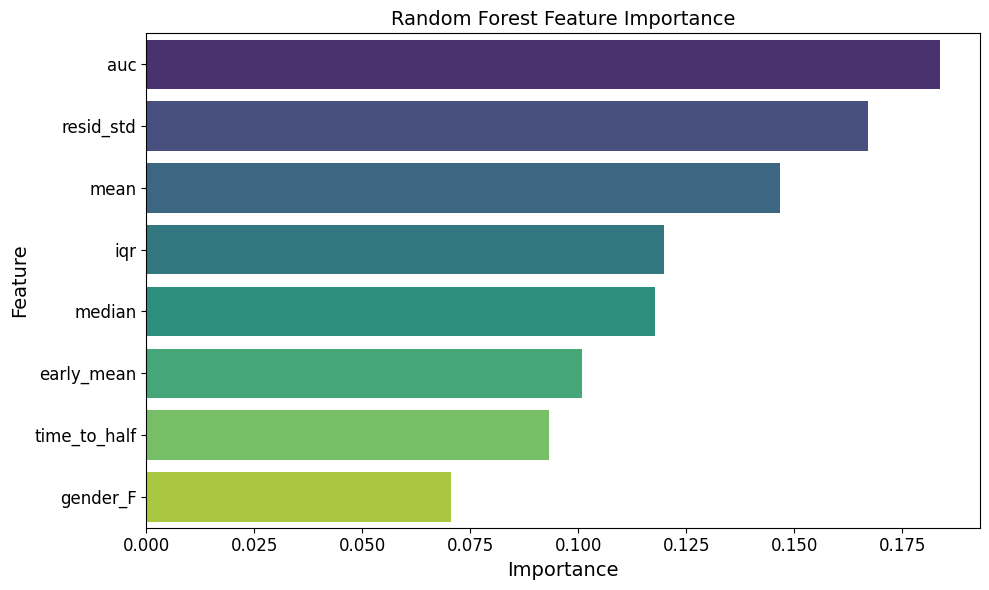

In [100]:
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    palette='viridis'
)
plt.title('Random Forest Feature Importance', fontsize=14)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

**Permutation importance**

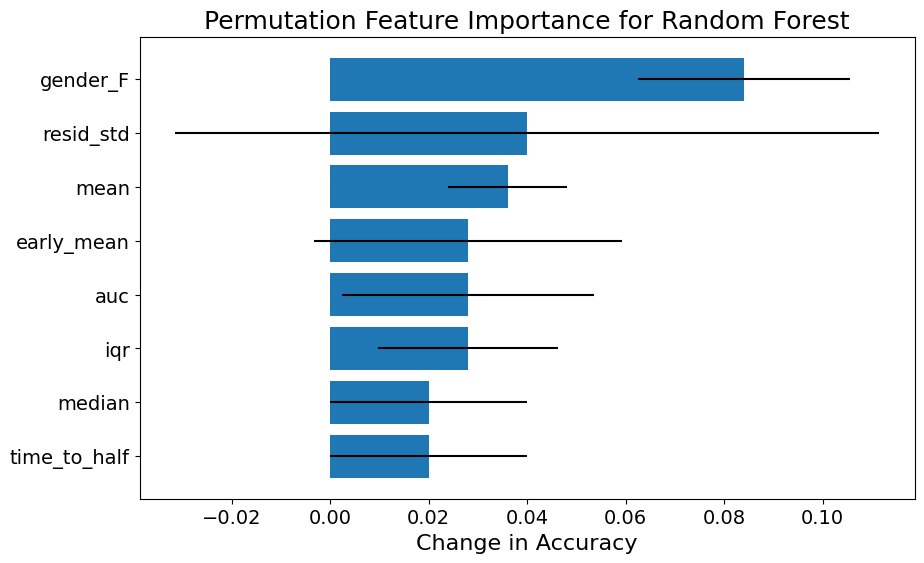

In [152]:
result = permutation_importance(best_rf, X_val, y_val, n_repeats=10, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_val.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'])
plt.gca().invert_yaxis()
plt.title("Permutation Feature Importance for Random Forest", fontsize=18)
plt.xlabel("Change in Accuracy", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**SHAP**

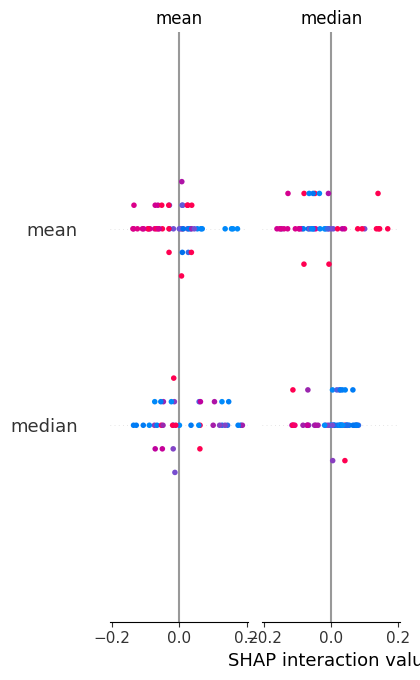

In [148]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

**LIME**

In [125]:
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=['Negative', 'Positive'],
    mode='classification'
)

In [128]:
i = 0  # index of sample to explain
exp = explainer.explain_instance(X_test.values[i], best_rf.predict_proba, num_features=5)

In [129]:
from IPython.display import display, HTML

html = exp.as_html()
display(HTML(html))

**Uncertainty**

Aleatoric uncertainty

In [162]:
def estimate_aleatoric_uncertainty(model, X_test, noise_level=0.01, n_samples=100):
    X_test = np.array(X_test)
    aleatoric_uncertainty = []

    for x in X_test:
        noisy_preds = []
        for _ in range(n_samples):
            x_noisy = x + np.random.normal(0, noise_level, size=x.shape)
            pred = model.predict(x_noisy.reshape(1, -1))[0]
            noisy_preds.append(pred)
        aleatoric_uncertainty.append(np.var(noisy_preds))

    return np.array(aleatoric_uncertainty)

In [122]:
aleatoric_uncertainty = estimate_aleatoric_uncertainty(best_rf, X_test, noise_level=0.01, n_samples=100)

array([0.1131, 0.    , 0.    , 0.    , 0.2451, 0.1344, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.0291, 0.    , 0.    , 0.2275, 0.2176,
       0.1056, 0.1056, 0.0819, 0.    , 0.    , 0.0196, 0.    , 0.1771,
       0.    , 0.    , 0.1411, 0.0819, 0.2379, 0.2176, 0.    , 0.1659,
       0.0384, 0.16  , 0.1875, 0.2275, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.1056, 0.25  , 0.    , 0.0736, 0.    , 0.0099, 0.0196,
       0.    ])

In [123]:
print("Mean aleatoric uncertainty:", np.mean(aleatoric_uncertainty))
print("Max aleatoric uncertainty:", np.max(aleatoric_uncertainty))
print("Samples with uncertainty > 0.2:", np.sum(aleatoric_uncertainty > 0.2))

Mean aleatoric uncertainty: 0.06883877551020408
Max aleatoric uncertainty: 0.25
Samples with uncertainty > 0.2: 7


Epistemic (model) uncertainty

Ensemble variance

In [120]:
tree_preds = [tree.predict(X_test) for tree in best_rf.estimators_]
epistemic_uncertainty = np.var(tree_preds, axis=0)
epistemic_uncertainty.mean()

0.1646418367346939

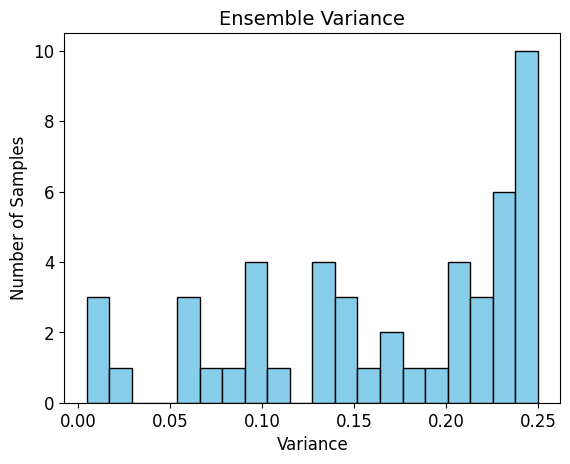

In [160]:
plt.hist(epistemic_uncertainty, bins=20, color='skyblue', edgecolor='black')
plt.title("Ensemble Variance", fontsize=14)
plt.xlabel("Variance", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Confidence scores - predictive posterior

In [110]:
tree_probs = np.array([tree.predict_proba(X_test) for tree in best_rf.estimators_])
avg_probs = tree_probs.mean(axis=0)
predictive_entropy = entropy(avg_probs.T)  # uncertainty per sample
predictive_entropy

array([0.61889268, 0.45588621, 0.30482296, 0.07788251, 0.68945244,
       0.69138099, 0.47889114, 0.46372644, 0.6590424 , 0.03147907,
       0.52050638, 0.67929128, 0.54862249, 0.60779438, 0.69136563,
       0.65624087, 0.34010032, 0.6778152 , 0.59432539, 0.66658041,
       0.25502247, 0.10076856, 0.52690796, 0.64946282, 0.06166959,
       0.64233616, 0.57730448, 0.42341055, 0.69218252, 0.67205273,
       0.22581951, 0.42637097, 0.6390537 , 0.65531403, 0.69294717,
       0.68254986, 0.43966988, 0.35684302, 0.37677016, 0.2908144 ,
       0.67702356, 0.65196621, 0.61010199, 0.33707865, 0.44549638,
       0.22843902, 0.49155563, 0.60467234, 0.34556394])

In [161]:
predictive_entropy.mean()

0.4945564785604144

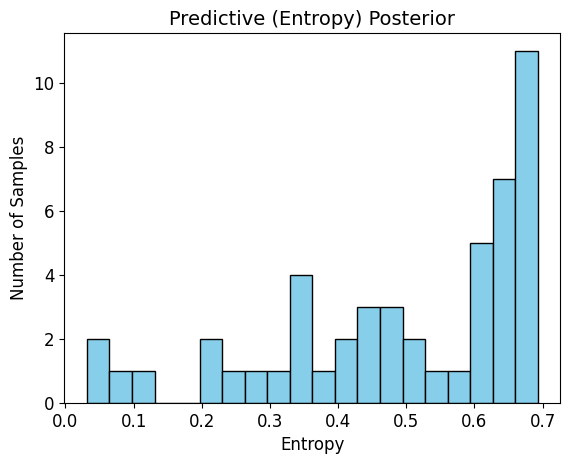

In [154]:
plt.hist(predictive_entropy, bins=20, color='skyblue', edgecolor='black')
plt.title("Predictive (Entropy) Posterior", fontsize=14)
plt.xlabel("Entropy", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [113]:
threshold = 0.6
uncertain_indices = np.where(predictive_entropy > threshold)[0]
print("High uncertainty samples:", uncertain_indices)

High uncertainty samples: [ 0  4  5  8 11 13 14 15 17 19 23 25 28 29 32 33 34 35 40 41 42 47]


In [117]:
print("Mean epistemic uncertainty:", round(predictive_entropy.mean(), 3))

Mean epistemic uncertainty: 0.495


In [54]:
class_names = ['Negative', 'Positive']
cm = confusion_matrix(y_test, best_rf.predict(X_test))

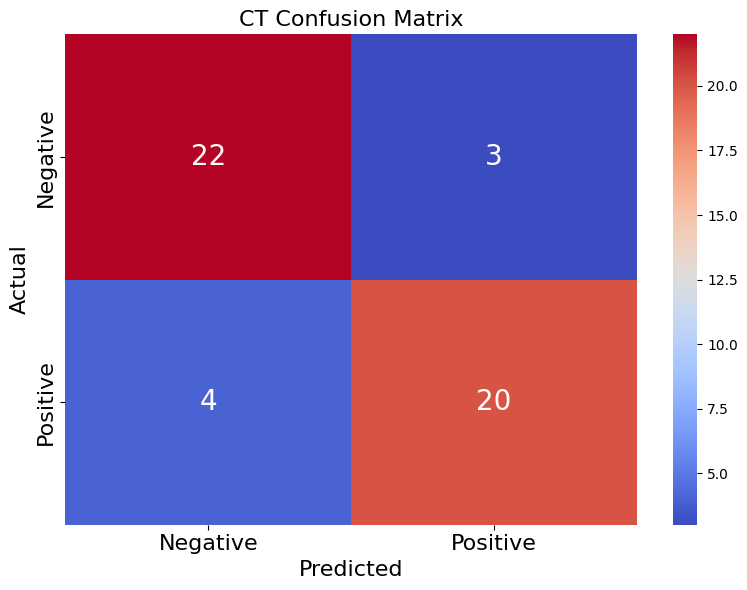

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names,
           annot_kws={"size": 20})
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('CT Confusion Matrix', fontsize=16)
plt.tight_layout()
plt.show()

### Hypertuning tuning - XGBoost

In [85]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5]
}

xgboost_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

best_xgb = train_model(xgboost_model, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 1.0}
Best cross-validation score: 0.8267379679144385

Classification report for training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        84

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Training ROC-AUC score: 1.0

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.65      0.92      0.76        12
           1       0.88      0.54      0.67        13

    accuracy                           0.72        25
   macro avg       0.76      0.73      0.71        25
weighted avg       0.77      0.72      0.71        25

Validation ROC-AUC score: 0.

### Hyperparameter tuning - kNN

In [86]:
param_grid = {
    'n_neighbors': list(range(1, 21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # Only used with 'minkowski'
}

knn_clf = KNeighborsClassifier()

best_knn = train_model(knn_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best cross-validation score: 0.785204991087344

Classification report for training data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        84

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168

Training ROC-AUC score: 1.0

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.73      0.92      0.81        12
           1       0.90      0.69      0.78        13

    accuracy                           0.80        25
   macro avg       0.82      0.80      0.80        25
weighted avg       0.82      0.80      0.80        25

Validation ROC-AUC score: 0.8044871794871794

Classification report for testing data:

      

### Hyperparameter tuning - Ridge

In [87]:
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_clf = RidgeClassifier(random_state=42)

best_ridge = train_model(ridge_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'alpha': 1}
Best cross-validation score: 0.6547237076648841

Classification report for training data:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65        84
           1       0.65      0.73      0.69        84

    accuracy                           0.67       168
   macro avg       0.67      0.67      0.67       168
weighted avg       0.67      0.67      0.67       168

Training ROC-AUC score: 0.6666666666666667

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.73      0.62      0.67        13

    accuracy                           0.68        25
   macro avg       0.69      0.68      0.68        25
weighted avg       0.69      0.68      0.68        25

Validation ROC-AUC score: 0.6826923076923077

Classification report for testing data:

              precision    recall  f1-score   suppo

### Hyperparameter tuning - Logistic

In [88]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

log_clf = LogisticRegression(random_state=42)

best_log = train_model(log_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Best parameters: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.6549019607843137

Classification report for training data:
              precision    recall  f1-score   support

           0       0.68      0.63      0.65        84
           1       0.66      0.70      0.68        84

    accuracy                           0.67       168
   macro avg       0.67      0.67      0.67       168
weighted avg       0.67      0.67      0.67       168

Training ROC-AUC score: 0.6666666666666667

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.73      0.62      0.67        13

    accuracy                           0.68        25
   macro avg       0.69      0.68      0.68        25
weighted avg       0.69      0.68      0.68        25

Validation ROC-AUC score: 0.6826923076923077

Classification report for testing

/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/alex/.conda/envs/general-stuff/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

### Hyperparameter tuning - SVC

In [89]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced']
}

svc_clf = SVC(random_state=42)

best_svc = train_model(svc_clf, param_grid, X_train, y_train, X_val, y_val, X_test, y_test, evaluate_test=True)

Best parameters: {'C': 100, 'class_weight': None, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation score: 0.7616755793226381

Classification report for training data:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        84
           1       0.95      0.82      0.88        84

    accuracy                           0.89       168
   macro avg       0.89      0.89      0.89       168
weighted avg       0.89      0.89      0.89       168

Training ROC-AUC score: 0.8869047619047619

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.82      0.69      0.75        13

    accuracy                           0.76        25
   macro avg       0.77      0.76      0.76        25
weighted avg       0.77      0.76      0.76        25

Validation ROC-AUC score: 0.7628205128205129

Classification report for testing data

### Voting Classification

In [90]:
voting_clf = VotingClassifier(
    estimators=[('dt', best_dt), ('knn', best_knn), ('logistic', best_log), ('ridge', best_ridge)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     random_state=42)),
                             ('knn',
                              KNeighborsClassifier(metric='euclidean',
                                                   n_neighbors=11, p=1,
                                                   weights='distance')),
                             ('logistic',
                              LogisticRegression(C=10, random_state=42,
                                                 solver='liblinear')),
                             ('ridge',
                              RidgeClassifier(alpha=1, random_state=42))])

In [91]:
print("Classification report for training data:")
print(classification_report(y_train, voting_clf.predict(X_train)))
print("Training ROC-AUC score:", roc_auc_score(y_train, voting_clf.predict(X_train)), end='\n\n')

print("Classification report for validation data:\n")
print(classification_report(y_val, voting_clf.predict(X_val)))
print("Validation ROC-AUC score:", roc_auc_score(y_val, voting_clf.predict(X_val)), end='\n\n')

print("Classification report for validation data:\n")
print(classification_report(y_test, voting_clf.predict(X_test)))
print("Validation ROC-AUC score:", roc_auc_score(y_test, voting_clf.predict(X_test)), end='\n\n')

Classification report for training data:
              precision    recall  f1-score   support

           0       0.77      0.89      0.82        84
           1       0.87      0.73      0.79        84

    accuracy                           0.81       168
   macro avg       0.82      0.81      0.81       168
weighted avg       0.82      0.81      0.81       168

Training ROC-AUC score: 0.8095238095238096

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.69      0.92      0.79        12
           1       0.89      0.62      0.73        13

    accuracy                           0.76        25
   macro avg       0.79      0.77      0.76        25
weighted avg       0.79      0.76      0.76        25

Validation ROC-AUC score: 0.7660256410256411

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.69      0.88      0.77        25
           1      

In [78]:
print("Classification report for validation data:\n")
print(classification_report(y_val, voting_clf.predict(X_val)))
print("Validation ROC-AUC score:", roc_auc_score(y_val, voting_clf.predict(X_val)), end='\n\n')

Classification report for validation data:

              precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.73      0.62      0.67        13

    accuracy                           0.68        25
   macro avg       0.69      0.68      0.68        25
weighted avg       0.69      0.68      0.68        25

Validation ROC-AUC score: 0.6826923076923077



In [ ]:
print("Classification report for validation data:\n")
print(classification_report(y_test, voting_clf.predict(X_test)))
print("Validation ROC-AUC score:", roc_auc_score(y_test, voting_clf.predict(X_test)), end='\n\n')

### Best Scores

#### Initial feature evaluation

In [79]:
models = {
    'decision_tree': best_dt,
    'random_forest': best_rf,
    'xgboost': best_xgb,
    'knn': best_knn,
    'ridge': best_ridge,
    'logistic': best_log,
    'svc': best_svc
}

results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    train_acc = round(accuracy_score(y_train, model.predict(X_train)), 3)
    val_acc = round(accuracy_score(y_val, model.predict(X_val)), 3)
    cv_acc = round(cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean(), 3)
    
    results.append({
        'Model': name,
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Cross-Validation Accuracy': cv_acc
    })

best_accs = pd.DataFrame(results)
best_accs['Training Accuracy'] = best_accs['Training Accuracy']*100
best_accs['Validation Accuracy'] = best_accs['Validation Accuracy']*100
best_accs['Cross-Validation Accuracy'] = best_accs['Cross-Validation Accuracy']*100
best_accs = best_accs.sort_values(by='Validation Accuracy', ascending=False)
best_accs

Model  Training Accuracy  Validation Accuracy  \
3            knn              100.0                 80.0   
1  random_forest               92.9                 68.0   
0  decision_tree               97.6                 68.0   
2        xgboost               94.0                 68.0   
4          ridge               86.3                 68.0   
6            svc               85.7                 68.0   
5       logistic               86.3                 64.0   

   Cross-Validation Accuracy  
3                       78.0  
1                       86.3  
0                       87.0  
2                       86.9  
4                       85.7  
6                       84.5  
5                       84.5

#### Final test results

In [92]:
models = {
    'decision_tree': best_dt,
    'random_forest': best_rf,
    'xgboost': best_xgb,
    'knn': best_knn,
    'ridge': best_ridge,
    'logistic': best_log,
    'svc': best_svc,
    'voting': voting_clf
}

results = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    train_acc = round(accuracy_score(y_train, model.predict(X_train)), 3)
    val_acc = round(accuracy_score(y_val, model.predict(X_val)), 3)
    test_acc = round(accuracy_score(y_test, model.predict(X_test)), 3)
    cv_acc = round(cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean(), 3)
    
    results.append({
        'Model': name,
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Testing Accuracy': test_acc,
        'Cross-Validation Accuracy': cv_acc
    })

best_accs = pd.DataFrame(results)
best_accs['Training Accuracy'] = best_accs['Training Accuracy']*100
best_accs['Validation Accuracy'] = best_accs['Validation Accuracy']*100
best_accs['Testing Accuracy'] = best_accs['Testing Accuracy']*100
best_accs['Cross-Validation Accuracy'] = best_accs['Cross-Validation Accuracy']*100
best_accs = best_accs.sort_values(by='Testing Accuracy', ascending=False)
best_accs

Model  Training Accuracy  Validation Accuracy  Testing Accuracy  \
0  decision_tree               88.1                 76.0              87.8   
1  random_forest              100.0                 84.0              85.7   
3            knn              100.0                 80.0              83.7   
2        xgboost              100.0                 72.0              75.5   
6            svc               88.7                 76.0              75.5   
7         voting               81.0                 76.0              73.5   
5       logistic               66.7                 68.0              65.3   
4          ridge               66.7                 68.0              65.3   

   Cross-Validation Accuracy  
0                       78.0  
1                       83.8  
3                       78.5  
2                       82.7  
6                       76.2  
7                       72.6  
5                       65.5  
4                       65.5

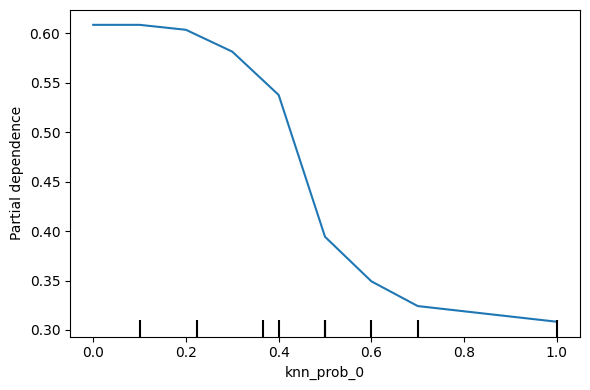

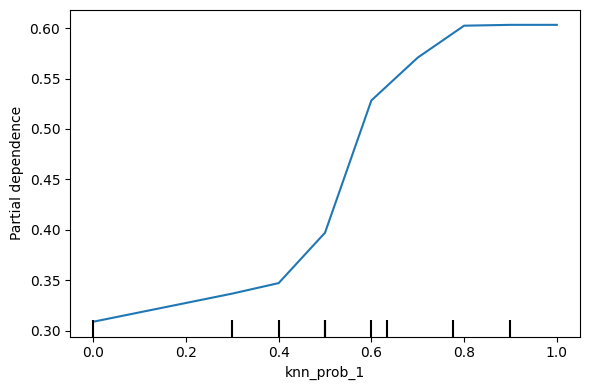

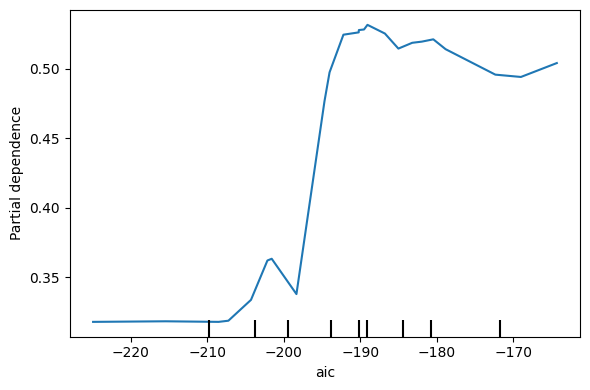

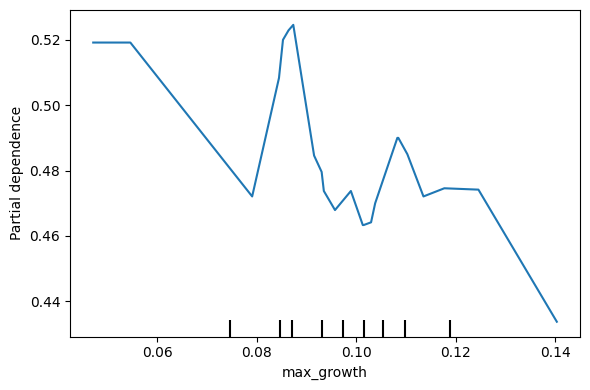

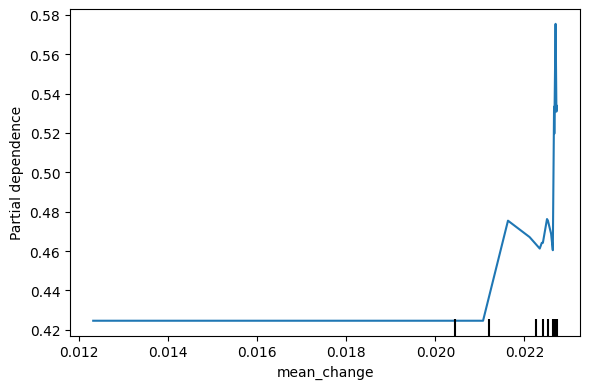

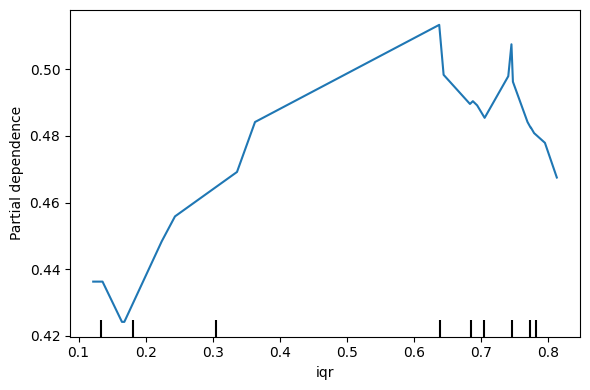

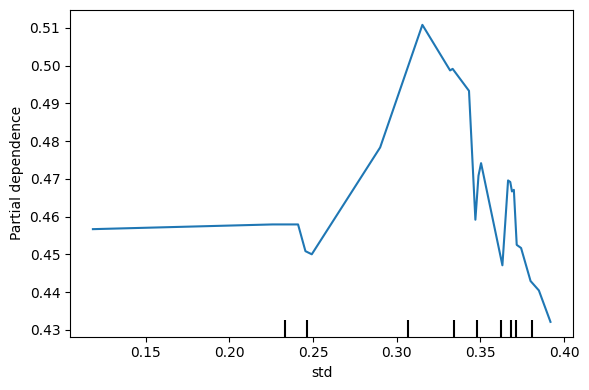

In [101]:
features_to_visualise = ['knn_prob_0', 'knn_prob_1', 'aic', 'max_growth', 'mean_change', 'iqr',
       'std']

for feature in features_to_visualise:
    fig, ax = plt.subplots(figsize=(6, 4))
    PartialDependenceDisplay.from_estimator(
        best_rf,
        X_val,
        features=[feature],
        kind='average',
        grid_resolution=50,
        ax=ax
    )
    plt.tight_layout()
    plt.show()